In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import mysql.connector
import pandas as pd
import numpy as np

import mysql.connector
import pandas as pd

# MySQL 연결 설정
cnx = mysql.connector.connect(
    host='',
    user='',
    password='',
    database=''
)

# 쿼리 생성
query_ball = "SELECT * FROM ball_df"
query_sequence_df = "SELECT * FROM sequence_df"
query_events_df = "SELECT * FROM events_df"

# DataFrame으로 읽기
ball_df = pd.read_sql(query_ball, con=cnx)
sequence_df = pd.read_sql(query_sequence_df, con=cnx)
events_df = pd.read_sql(query_events_df, con=cnx)

# 연결 종료 (선택적)
cnx.close()

In [9]:
ball_df = ball_df.drop(columns='index')

In [10]:
events_df

,level_0,index,frame,x,y,event,player,height,bounce
0,0,0,18,566,200,bounce,player_A,NaN,left
1,1,1,33,897,228,net,player_A,0.13,None
2,2,2,44,500,138,bounce,player_A,NaN,right
3,3,3,2192,1305,110,bounce,player_B,NaN,left
4,4,4,2211,889,240,net,player_B,0.17,None
...,...,...,...,...,...,...,...,...,...
330,330,372,79170,643,199,bounce,player_B,NaN,right
331,331,373,79225,893,239,net,player_A,0.17,None
332,332,374,79236,1113,144,bounce,player_A,NaN,right
333,333,375,79276,909,258,net,player_B,0.23,None


In [11]:
# ball_df.to_csv('ball_df.csv')
# sequence_df.to_csv('sequence_df.csv')
# events_df.to_csv('events_df.csv')

sequecne 구간을 설정하면 해당 sequence별로 공의 움직임과 각종 분석 정보들을 볼 수 있는 시각화를 생성합니다.\
\
vscode에서는 애니메이션 효과를 못보기 때문에 공의 움직임 애니메이션은 추후 jupyer notebook 전용 시각화를 생성합니다.

In [5]:
# 시각화할 sequence 구간을 미리 설정해줍니다.

sequence_range = range(1, 10)

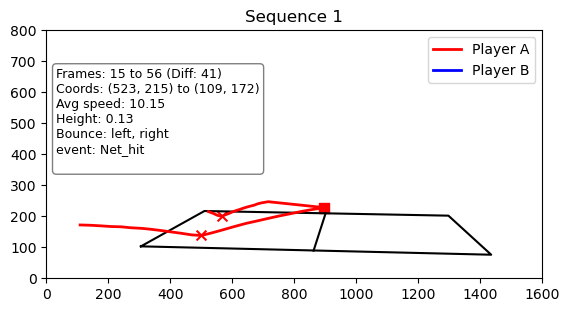

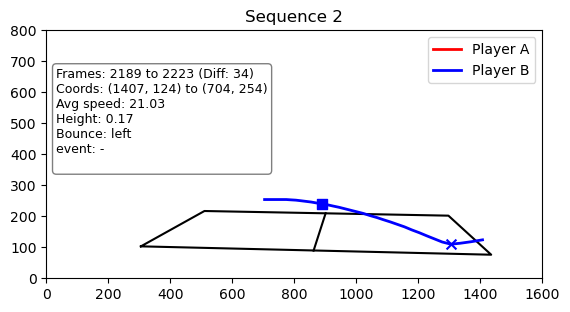

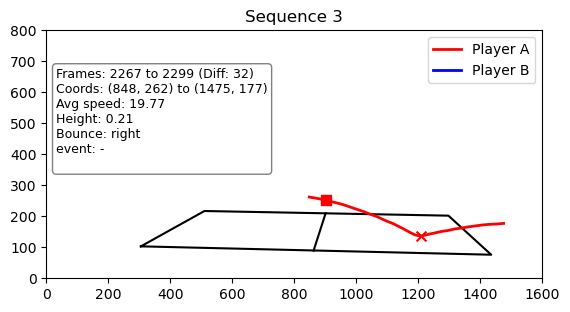

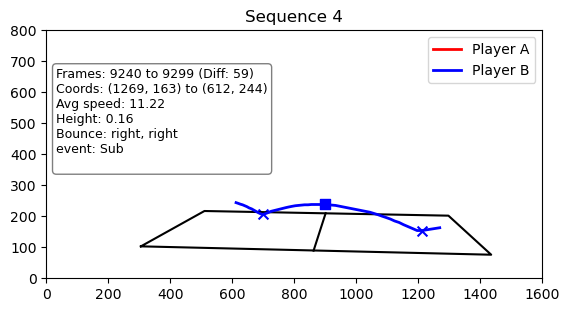

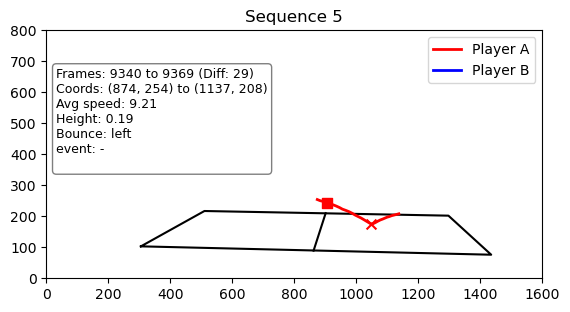

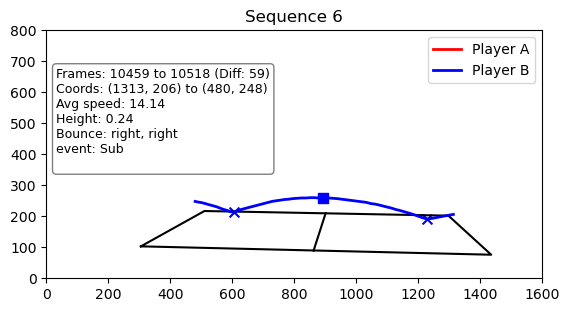

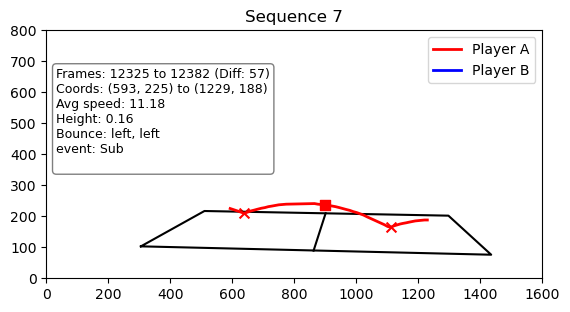

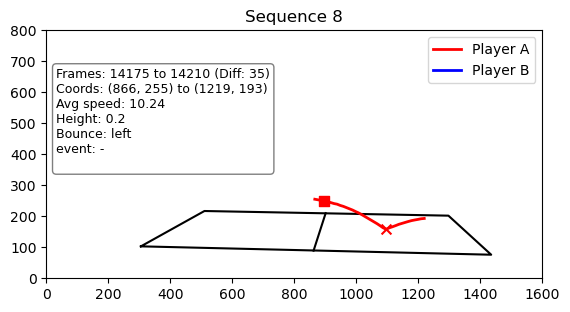

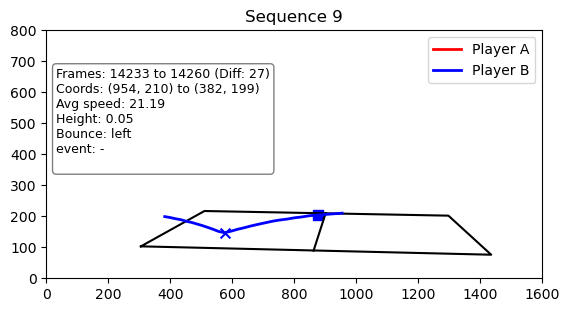

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# 테이블과 네트 좌표
table_corners = {'left_bottom': (305, 103),
                 'left_top': (510, 217),
                 'right_top': (1297, 202),
                 'right_bottom': (1435, 76)}
net_coords = [(901, 210), (862, 89)]

# 테이블과 네트 그리는 함수
def plot_table_and_net(ax, table_corners, net_coords):
    # 테이블 그리기
    table_x = [table_corners['left_bottom'][0], table_corners['left_top'][0],
               table_corners['right_top'][0], table_corners['right_bottom'][0],
               table_corners['left_bottom'][0]]
    table_y = [table_corners['left_bottom'][1], table_corners['left_top'][1],
               table_corners['right_top'][1], table_corners['right_bottom'][1],
               table_corners['left_bottom'][1]]
    ax.plot(table_x, table_y, 'k-')

    # 네트 그리기
    net_x, net_y = zip(*net_coords)
    ax.plot(net_x, net_y, 'k-')

# 각 시퀀스에 대해 별도의 플롯 생성
for seq in sequence_range:
    fig, ax = plt.subplots()
    ax.set_xlim(0, 1600)
    ax.set_ylim(0, 800)
    ax.set_title(f"Sequence {seq}")
    ax.set_aspect('equal', adjustable='box')
    plot_table_and_net(ax, table_corners, net_coords)

    # 시퀀스 데이터 필터링
    sequence_data = ball_df[ball_df['sequence'] == seq]
    sequence_info = sequence_df[sequence_df['sequence'] == seq].iloc[0]
    events_data = events_df[events_df['frame'].isin(sequence_data['frame'])]

    # 시퀀스 정보 및 이벤트 정보를 표시할 텍스트 초기화
    seq_info_text = (f"Frames: {sequence_info['frame_1']} to {sequence_info['frame_2']} "
                     f"(Diff: {sequence_info['diff_frame']})\n"
                     f"Coords: ({sequence_info['x1']}, {sequence_info['y1']}) to "
                     f"({sequence_info['x2']}, {sequence_info['y2']})\n"
                     f"Avg speed: {sequence_info['avg_velocity']}\n")  # 평균 속도 추가

    # 이벤트 정보 수집
    bounce_events = []
    for _, row in events_data.iterrows():
        if pd.notnull(row['height']):
            seq_info_text += f"Height: {row['height']}\n"
        if pd.notnull(row['bounce']):
            bounce_events.append(row['bounce'])

    # 모든 bounce 이벤트를 하나의 문자열로 결합
    if bounce_events:
        seq_info_text += f"Bounce: {', '.join(bounce_events)}\n"
    else:
        seq_info_text += "Bounce: None\n"

    # net_hit, sub 이벤트 추가
    event_text = "event: "
    if sequence_info['net_hit'] == 1:
        event_text += "Net_hit"
    elif sequence_info['sub'] == 1:
        event_text += "Sub"
    else:
        event_text += "-"

    seq_info_text += event_text + "\n"

    # 시퀀스 정보 및 이벤트 정보 표시
    ax.text(0.02, 0.85, seq_info_text, transform=ax.transAxes, fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5), color='black')

    # 플레이어별로 데이터 그리기
    for player in ['A', 'B']:
        player_data = sequence_data[sequence_data['player'] == f'player_{player}']
        color = 'red' if player == 'A' else 'blue'  # 색상을 player_A: 빨간색, player_B: 파란색으로 설정
        ax.plot(player_data['x'], player_data['y'], color=color, lw=2, label=f"Player {player}")

        # 이벤트 마커 그리기
        player_events = events_data[events_data['player'] == f'player_{player}']
        for _, row in player_events.iterrows():
            marker = 's' if row['event'] == 'net' else 'x'
            ax.scatter(row['x'], row['y'], s=50, c=color, marker=marker)

    # 범례 추가
    ax.legend(loc='upper right')

plt.show()